## Sickness absence scraper from NHSD published stats
#### Load in data from websites

In [1]:

### Script to scrape published data from NHSD webpages and output a compiled and procesed CSV
### of FTE days available and FTE days lost by staff group and organisation
### Takes up to 10 minutes to run

import pandas as pd
import requests
from datetime import datetime
from bs4 import BeautifulSoup

# Allows unverified SSLs
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# The monthly publication of sickness absences sometimes vary in format (sometimes monthly "provisional", sometimes just monthly, sometimes quarterly)
# These three base URLs pick up on all variations. The code iterates through all possible URL formats for each month (and quarter). Where an invalid
# URL is created, the code will output "Failed to access [URL]", where it is valid it will output "Downloaded and parsed: [URL]". All data about 
# failed/successful access is outputted in a seperate CSV.

base_urls = [
    "https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/{month}-{year}-provisional-statistics",
    "https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/{month}-{year}",
    "https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/{month1}-{year1}-to-{month2}-{year2}-provisional-statistics"
]

accessed_data = []
dfs = []

## Function to get quarterly month values

def get_month_range_quarterly(month):
    quarters = {
        "january": ("january", "march"),
        "april": ("april", "june"),
        "july": ("july", "september"),
        "november": ("november", "december")
    }
    return quarters.get(month, (None, None))

## Iterates over years and months - specify years in range (remember need to +1 to upper range)

for year in range(2018, 2024):
    for month in range(1, 13):
        month_name = datetime(year, month, 1).strftime('%B').lower()

        for base_url in base_urls:
            ## Gets correct year for quarter
            if "{month1}-{year1}-to-{month2}-{year2}" in base_url:
                start_month, end_month = get_month_range_quarterly(month_name)
                if not start_month:
                    continue
                month1 = start_month
                month2 = end_month
                year1 = year
                year2 = year
                if end_month == "december":
                    year2 += 1
                url = base_url.format(month1=month1, year1=year1, month2=month2, year2=year2)
            else:
                url = base_url.format(month=month_name, year=year)

            # Download the monthly webpage
            response = requests.get(url)
            if response.status_code == 200:
                # Parse the HTML content of the monthly webpage
                soup = BeautifulSoup(response.content, "html.parser")
                # Find all the CSV links on the monthly webpage
                csv_links = soup.select('a[href$=".csv"]')

                # Append the accessed webpage to the accessed_data list
                accessed_data.append({"URL": url, "Status": "Accessed", "CSV Count": len(csv_links)})

                # Iterate over the CSV links and download the files
                for link in csv_links:
                    csv_url = link["href"]
                    # Download the CSV file
                    response_csv = requests.get(csv_url)
                    if response_csv.status_code == 200:
                        # Read the CSV data into a DataFrame
                        df = pd.read_csv(csv_url)
                        # Add a new column with the downloaded URL
                        df["Downloaded From"] = csv_url
                        # Append the downloaded data to the dfs list
                        dfs.append(df)
                        # Append the downloaded CSV URL to the downloaded_data list
                        accessed_data.append({"URL": csv_url, "Status": "Downloaded"})
                        print(f"Downloaded and parsed: {csv_url}")
                    else:
                        # Append the failed CSV URL to the downloaded_data list
                        accessed_data.append({"URL": csv_url, "Status": "Failed"})
                        print(f"Failed to download CSV from {csv_url}")
                break  # Exit the loop if CSV files were found and downloaded
            else:
                # Append the failed webpage to the accessed_data list
                accessed_data.append({"URL": url, "Status": "Failed", "CSV Count": 0})
                print(f"Failed to access webpage: {url}")

accessed_df = pd.DataFrame(accessed_data)
combined_df = pd.concat(dfs, ignore_index=True)

# Optional: Save the accessed_df to separate CSV file
accessed_df.to_csv("tempdir/accessed_data.csv", index=False)


Failed to access webpage: https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/january-2018-provisional-statistics
Failed to access webpage: https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/january-2018
Failed to access webpage: https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/january-2018-to-march-2018-provisional-statistics
Failed to access webpage: https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/february-2018-provisional-statistics
Failed to access webpage: https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/february-2018
Failed to access webpage: https://digital.nhs.uk/data-and-information/publications/statistical/nhs-sickness-absence-rates/march-2018-provisional-statistics
Failed to access webpage: https://digital.nhs.uk/data-and-information/publications/s

In [2]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7660846 entries, 0 to 7660845
Data columns (total 50 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Date                           object 
 1   HEE_region_code                object 
 2   HEE_region_name                object 
 3   Org Code                       object 
 4   Org Name                       object 
 5   Org Type                       object 
 6   FTE Days Sick                  float64
 7   FTE Days Available             float64
 8   SA Rate (%)                    float64
 9   Sort_Date                      float64
 10  Downloaded From                object 
 11  Month                          object 
 12  Org code                       object 
 13  Org name                       object 
 14  HEE region code                object 
 15  HEE region name                object 
 16  Cluster group                  object 
 17  Benchmark group                object 
 18  NH

### Process and save sickness absence data

In [3]:
# Filter the 'Downloaded From' for cells containing "benchmarking" because that picks up on
# sickness absence benchmarking data which is in the format we want. 
absence_df = combined_df[combined_df['Downloaded From'].str.contains('benchmarking')].dropna(axis = 1, 
                                                                                             how = 'all').dropna(axis = 0, 
                                                                                             how = 'all').reset_index(drop=True)

In [4]:
# Convert the 'Month' column to datetime format
absence_df['Month'] = pd.to_datetime(absence_df['Month'], errors='coerce')

# Convert Month column dates to the format 'YYYY-MM-DD'
absence_df['Month'] = absence_df['Month'].dt.to_period('M').dt.to_timestamp()
#absence_df['Month'].unique()

C:\Users\MarieRogers\AppData\Local\Temp\ipykernel_10988\3911965387.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  absence_df['Month'] = pd.to_datetime(absence_df['Month'], errors='coerce')


In [5]:
# Merge 'Month' and 'DATE' columns into a single column 'Date'
absence_df['Date'] = absence_df['Month'].combine_first(absence_df['DATE'])

# Drop old dates columns
absence_df = absence_df.drop(['Month','DATE'], axis=1)


C:\Users\MarieRogers\AppData\Local\Temp\ipykernel_10988\2699082207.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  absence_df['Date'] = absence_df['Month'].combine_first(absence_df['DATE'])


In [6]:
# Do the same thing for all columns containing same data category but different names
columns_to_merge = {
    'NHSE region code': 'NHSE_REGION_CODE',
    'NHSE region name': 'NHSE_REGION_NAME',
    'Org code': 'ORG_CODE',
    'Org name': 'ORG_NAME',
    'FTE days lost': 'FTE_DAYS_LOST',
    'FTE days available': 'FTE_DAYS_AVAILABLE',
    'Sickness absence rate (%)': 'SICKNESS_ABSENCE_RATE_PERCENT',
    'Staff group': 'STAFF_GROUP',
    'Cluster group': 'CLUSTER_GROUP',
    'Benchmark group': 'BENCHMARK_GROUP',
}


In [7]:
# Iterate over the columns to merge
for column, matching_column in columns_to_merge.items():
    # Check if both columns exist in the dataframe
    if column in absence_df.columns and matching_column in absence_df.columns:
        # Merge the columns by filling the missing values
        absence_df[column] = absence_df[column].fillna(absence_df[matching_column])

# Drop the matching columns so only the merged column remains
absence_df = absence_df.drop(columns_to_merge.values(), axis=1)


In [8]:
# clean up and simplify data frame
to_drop = ['Downloaded From','Tm End Date','ICS_CODE','ICS_NAME','HEE region code',
         'HEE region name','Sickness absence rate (%)']
replace_dict_region = {'South East of England':'South East',
                'South West of England':'South West'}
replace_dict_staff = {'All staff':'All staff groups',
                'HCHS Doctors':'HCHS doctors (exc. junior Drs)',
                'HCHS doctors':'HCHS doctors (exc. junior Drs)'}
df = absence_df.sort_values('Date')
df['NHSE region name'] = df['NHSE region name'].replace(replace_dict_region)
df['Staff group'] = df['Staff group'].replace(replace_dict_staff)
df.drop(to_drop,axis=1, inplace=True)
order = ['Date','Org code','Org name','NHSE region code','NHSE region name','Cluster group','Benchmark group',
         'Staff group','FTE days lost','FTE days available']
df = df.drop_duplicates()
df = df[order].reset_index(drop=True)

In [11]:
# remove rows where 'fte days available' is nan as assume no data available
df = df.dropna(subset=['FTE days available'])


In [12]:
df.to_csv('../sickness_absence.csv', index=False)

### Process and save sickness absence *reason* data

Filter the 'Downloaded From' for cells containing "REASON" because that picks up on sickness absence reason data. Drop other columns that contain all NAs.

In [205]:
reason_df = combined_df[combined_df['Downloaded From'].str.contains('REASON')].dropna(axis = 1, 
                                                                                      how = 'all').dropna(axis = 0, 
                                                                                      how = 'all').reset_index(drop=True)

reason_df = reason_df.drop(['Downloaded From'], axis=1)
reason_df.tail()

,Month,Staff group,Type,Reason,FTE days
815243,2022-05-31,Support to ST&T staff,FTE days lost,S19 Heart cardiac & circulatory problems,2743.13902
815244,2022-05-31,Support to ST&T staff,FTE days lost,S22 Dental and oral problems,724.98313
815245,2022-05-31,Support to ST&T staff,FTE days lost,S25 Gastrointestinal problems,10779.34566
815246,2022-05-31,Support to ST&T staff,FTE days lost,S28 Injury fracture,6119.54233
815247,2022-05-31,Support to ST&T staff,FTE days lost,S99 Unknown causes / Not specified,3241.11150


Another approach to see if we can get later data - where REASON column is populated 

In [208]:
reason_df2 = combined_df[combined_df['REASON'].notna()].dropna(axis = 1, how = 'all').dropna(axis = 0, 
                                                                                      how = 'all').reset_index(drop=True)

In [209]:
reason_df2 = reason_df2.drop(['Downloaded From'], axis=1)


In [210]:
reason_df2.head()

,DATE,FTE_DAYS_LOST,FTE_DAYS_AVAILABLE,STAFF_GROUP,REASON
0,30/04/2022,2.266051e+06,3.933588e+07,All staff groups,ALL REASONS
1,30/04/2022,4.630816e+05,0.000000e+00,All staff groups,S10 Anxiety/stress/depression/other psychiatri...
2,30/04/2022,8.461698e+04,0.000000e+00,All staff groups,S11 Back Problems
3,30/04/2022,1.614129e+05,0.000000e+00,All staff groups,S12 Other musculoskeletal problems
4,30/04/2022,2.546760e+05,0.000000e+00,All staff groups,S13 Cold Cough Flu - Influenza


In [203]:
reason_df2.tail()

,DATE,FTE_DAYS_LOST,FTE_DAYS_AVAILABLE,STAFF_GROUP,REASON
6440,28/02/2023,2.00000,0.0,Staff Grade,S21 Ear nose throat (ENT)
6441,28/02/2023,6.89375,0.0,Staff Grade,S25 Gastrointestinal problems
6442,28/02/2023,7.00000,0.0,Staff Grade,S27 Infectious diseases
6443,28/02/2023,35.56000,0.0,Staff Grade,S98 Other known causes - not elsewhere classified
6444,28/02/2023,11.95000,0.0,Staff Grade,S99 Unknown causes / Not specified


Looks like this is where the rest of the data are so we need to stitch together these dfs

In [211]:
# Convert the 'Month' column to datetime format
reason_df['Month'] = pd.to_datetime(reason_df['Month'], errors='coerce')

# Convert Month column dates to the format 'YYYY-MM-DD'
reason_df['Month'] = reason_df['Month'].dt.to_period('M').dt.to_timestamp()

#reason_df['Month'].unique()

In [212]:
# Convert the 'Month' column to datetime format
reason_df2['DATE'] = pd.to_datetime(reason_df2['DATE'], errors='coerce')

# Convert Month column dates to the format 'YYYY-MM-DD'
reason_df2['DATE'] = reason_df2['DATE'].dt.to_period('M').dt.to_timestamp()

#reason_df['Month'].unique()

C:\Users\MarieRogers\AppData\Local\Temp\ipykernel_10988\47329132.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  reason_df2['DATE'] = pd.to_datetime(reason_df2['DATE'], errors='coerce')


In [213]:
reason_df2.head()

,DATE,FTE_DAYS_LOST,FTE_DAYS_AVAILABLE,STAFF_GROUP,REASON
0,2022-04-01,2.266051e+06,3.933588e+07,All staff groups,ALL REASONS
1,2022-04-01,4.630816e+05,0.000000e+00,All staff groups,S10 Anxiety/stress/depression/other psychiatri...
2,2022-04-01,8.461698e+04,0.000000e+00,All staff groups,S11 Back Problems
3,2022-04-01,1.614129e+05,0.000000e+00,All staff groups,S12 Other musculoskeletal problems
4,2022-04-01,2.546760e+05,0.000000e+00,All staff groups,S13 Cold Cough Flu - Influenza


In [44]:
reason_df.rename(columns={'Month': 'Date'}, inplace=True)

In [45]:
#sorted(reason_df['Staff group'].unique())

In [125]:
reason_df.head()

,Date,Staff group,Type,Reason,FTE days
0,2015-01-01,All staff groups,FTE days available,All reasons,3.298616e+07
1,2015-01-01,Professionally qualified clinical staff,FTE days available,All reasons,1.778899e+07
2,2015-01-01,HCHS doctors,FTE days available,All reasons,3.300960e+06
3,2015-01-01,Associate Specialist,FTE days available,All reasons,8.038344e+04
4,2015-01-01,Consultant,FTE days available,All reasons,1.310032e+06


In [126]:
reason_df['Type'].unique()

array(['FTE days available', 'FTE days lost'], dtype=object)

In [48]:
#reason_df.to_csv('tempdir/sickness_absence_reason_unprocessed.csv', index=False)

In [127]:
# Pivot the 'Type' column using pivot_table
p_reason_df = pd.pivot_table(reason_df, index=['Date','Reason','Staff group'], columns=['Type'], values='FTE days', aggfunc='sum')

# Reset the index
p_reason_df.reset_index(inplace=True)


In [128]:
p_reason_df.head()

Type,Date,Reason,Staff group,FTE days available,FTE days lost
0,2015-01-01,All reasons,All staff groups,4.947924e+08,2.314284e+07
1,2015-01-01,All reasons,Ambulance staff,8.261049e+06,6.245611e+05
2,2015-01-01,All reasons,Associate Specialist,1.205752e+06,3.291103e+04
3,2015-01-01,All reasons,Central functions,4.329497e+07,1.597401e+06
4,2015-01-01,All reasons,Consultant,1.965047e+07,2.375077e+05


FTE days available is only recorded for all reasons (not broken down by sickness absence reason), so we can drop that column


In [129]:
p_reason_df = p_reason_df.drop(['FTE days available'], axis=1)

In [25]:
#p_reason_df.to_csv('tempdir/sickness_absence_reason_unprocessed.csv', index=False)

Import sickness absence reference table to decode reason information into a new column

In [159]:
url = 'REF_SICK_ABSENCE_REASONS.csv'
df_ref = pd.read_csv(url)
df_ref.rename(columns={'Sick_Lv1_Reason':'Reason','Sick_Lv1_Description':'Description'},inplace=True) 
df_ref.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Sick_Lv1_Code         377 non-null    object
 1   Reason                377 non-null    object
 2   Description           377 non-null    object
 3   Sick_Lv2_Code         377 non-null    object
 4   Sick_Lv2_Reason       377 non-null    object
 5   Sick_Lv2_Description  353 non-null    object
 6   reason_short          377 non-null    object
dtypes: object(7)
memory usage: 20.7+ KB


Add description information to main df

In [170]:
df_reason = pd.merge(p_reason_df, df_ref[['Reason','reason_short']], on='Reason',how='left')
df_reason.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584860 entries, 0 to 584859
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           584860 non-null  datetime64[ns]
 1   Reason         584860 non-null  object        
 2   Staff group    584860 non-null  object        
 3   FTE days lost  584860 non-null  float64       
 4   reason_short   567428 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 22.3+ MB


In [171]:
# remove rows where 'Description' is nan as this equates to no reason breakdown
df_reason = df_reason.dropna(subset=['reason_short'])

In [172]:
#drop Reason column as information now in Description
df_reason = df_reason.drop(['Reason'], axis=1)

In [173]:
# de-duplicate - now lots of duplicate rows
df_reason = df_reason.drop_duplicates()


In [174]:
df_reason.tail()

,Date,Staff group,FTE days lost,reason_short
584855,2022-05-01,Staff Grade,7.03750,unknown
584856,2022-05-01,Support to ST&T staff,3241.11150,unknown
584857,2022-05-01,Support to ambulance staff,2402.56053,unknown
584858,2022-05-01,Support to clinical staff,20610.35544,unknown
584859,2022-05-01,"Support to doctors, nurses & midwives",14966.68341,unknown


There are more staff groups in this data than in the independent variable data - need to compile HCHS doctors and then drop ones that don't match

In [175]:
sorted(df_reason['Staff group'].unique())

['All staff groups',
 'Ambulance staff',
 'Associate Specialist',
 'Central functions',
 'Consultant',
 'Core Training',
 'Foundation Doctor Year 1',
 'Foundation Doctor Year 2',
 'HCHS doctors',
 'Hospital Practitioner / Clinical Assistant',
 'Hotel, property & estates',
 'Managers',
 'Midwives',
 'NHS infrastructure support',
 'Nurses & health visitors',
 'Other and Local HCHS Doctor Grades',
 'Other staff or those with unknown classification',
 'Professionally qualified clinical staff',
 'Scientific, therapeutic & technical staff',
 'Senior managers',
 'Specialty Doctor',
 'Specialty Registrar',
 'Staff Grade',
 'Support to ST&T staff',
 'Support to ambulance staff',
 'Support to clinical staff',
 'Support to doctors, nurses & midwives']

In [178]:
clinical_grades = ['Specialty Doctor',
 'Specialty Registrar',
 'Staff Grade',
 'Professionally qualified clinical staff',
 'Other and Local HCHS Doctor Grades',
 'Hospital Practitioner / Clinical Assistant',
 'HCHS doctors',
 'Consultant',
 'Core Training',
 'Foundation Doctor Year 1',
 'Foundation Doctor Year 2',
 'Associate Specialist']


In [179]:
df_reason['Staff group'] = df_reason['Staff group'].replace('HCHS doctors','HCHS doctors (exc. junior Drs)')

In [180]:
sg_in_df_reason = df_reason['Staff group'].unique()
sg_in_df_absence = df['Staff group'].unique()

In [181]:
df_reason = df_reason[df_reason['Staff group'].isin(sg_in_df_absence)]


In [182]:
sorted(df['Staff group'].unique())

['All staff groups',
 'Ambulance staff',
 'Central functions',
 'HCHS doctors (exc. junior Drs)',
 'Hotel, property & estates',
 'Managers',
 'Midwives',
 'Nurses & health visitors',
 'Other staff or those with unknown classification',
 'Scientific, therapeutic & technical staff',
 'Senior managers',
 'Support to ST&T staff',
 'Support to ambulance staff',
 'Support to doctors, nurses & midwives']

In [183]:
sorted(df_reason['Staff group'].unique())

['All staff groups',
 'Ambulance staff',
 'Central functions',
 'HCHS doctors (exc. junior Drs)',
 'Hotel, property & estates',
 'Managers',
 'Midwives',
 'Nurses & health visitors',
 'Other staff or those with unknown classification',
 'Scientific, therapeutic & technical staff',
 'Senior managers',
 'Support to ST&T staff',
 'Support to ambulance staff',
 'Support to doctors, nurses & midwives']

Calculate proportion of sickness absence due each reason

In [184]:
# Calculate the total days lost by staff group, reason and 'date'
df_reason['total_days_lost'] = df_reason.groupby(['Staff group', 'Date'])['FTE days lost'].transform('sum')

# Calculate the percentage of days lost for each 'staff_group', 'reason', and 'date'
df_reason['percentage_days_lost'] = (df_reason['FTE days lost'] / df_reason['total_days_lost']) 


In [185]:
df_reason.tail()

,Date,Staff group,FTE days lost,reason_short,total_days_lost,percentage_days_lost
584851,2022-05-01,"Scientific, therapeutic & technical staff",4816.12428,unknown,146384.88432,0.032900
584852,2022-05-01,Senior managers,493.00811,unknown,5548.15377,0.088860
584856,2022-05-01,Support to ST&T staff,3241.11150,unknown,104176.61043,0.031112
584857,2022-05-01,Support to ambulance staff,2402.56053,unknown,56660.63564,0.042403
584859,2022-05-01,"Support to doctors, nurses & midwives",14966.68341,unknown,493700.28555,0.030315


In [141]:
#df_reason['Description'].unique()

In [186]:
df_reason_as_cols = df_reason.pivot_table(index=['Date','Staff group'], 
                                          columns='reason_short', values='percentage_days_lost', aggfunc='sum')


In [187]:
df_reason_as_cols.reset_index(inplace=True)
df_reason_as_cols

reason_short,Date,Staff group,anxiety_stress,asthma,back_problems,blood_disorder,dental,endocrine,eye,gastro,...,headache_mig,infectious_dis,nervous_system,other,other_msk,pregnancy_related,respiratory,skin_disorders,substance_abus,unknown
0,2015-01-01,All staff groups,0.240650,0.005032,0.081042,0.004611,0.005471,0.005315,0.009732,0.097381,...,0.019970,0.007180,0.009909,0.106754,0.130557,0.032406,0.072614,0.007171,0.000774,0.117233
1,2015-01-01,Ambulance staff,0.202620,0.000315,0.137649,0.002464,0.002704,0.003397,0.011103,0.078871,...,0.011826,0.004563,0.006138,0.048892,0.143986,0.009491,0.065409,0.005396,0.000386,0.244438
2,2015-01-01,Central functions,0.284872,0.004778,0.057931,0.004319,0.007318,0.005010,0.012109,0.105755,...,0.024926,0.007067,0.008558,0.112053,0.087178,0.020707,0.081521,0.005671,0.001851,0.128868
3,2015-01-01,HCHS doctors (exc. junior Drs),0.259820,0.003406,0.044700,0.005855,0.004394,0.003855,0.014988,0.101290,...,0.016285,0.006457,0.006837,0.142692,0.054098,0.033716,0.043481,0.003676,0.001021,0.230765
4,2015-01-01,"Hotel, property & estates",0.195991,0.003222,0.102186,0.006378,0.005601,0.003548,0.009676,0.096661,...,0.014650,0.008583,0.006566,0.118789,0.185406,0.012533,0.086398,0.009939,0.002620,0.095151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241,2022-05-01,"Scientific, therapeutic & technical staff",0.299827,0.002780,0.039535,0.003508,0.006129,0.004765,0.008729,0.102062,...,0.034684,0.112587,0.011545,0.073708,0.086431,0.038768,0.093175,0.006006,0.000369,0.032900
1242,2022-05-01,Senior managers,0.381579,0.003965,0.032083,0.004506,0.002523,0.010634,0.008021,0.050199,...,0.015957,0.079350,0.006669,0.138571,0.033597,0.023071,0.094360,0.000822,NaN,0.088860
1243,2022-05-01,Support to ST&T staff,0.312630,0.002810,0.057006,0.004620,0.006959,0.005160,0.011463,0.103472,...,0.035771,0.083623,0.015320,0.075481,0.108540,0.022243,0.081857,0.007725,0.000453,0.031112
1244,2022-05-01,Support to ambulance staff,0.319816,0.003317,0.080901,0.005631,0.005266,0.004698,0.008114,0.098365,...,0.031204,0.104323,0.010985,0.056427,0.094098,0.020951,0.077216,0.008331,0.000124,0.042403


In [188]:
df_reason_as_cols.to_csv('../sickness_absence_reason_pivot.csv', index=False)

In [145]:
df_reason_sg = df_reason.loc[df_reason['Staff group'] == 'Support to ambulance staff']

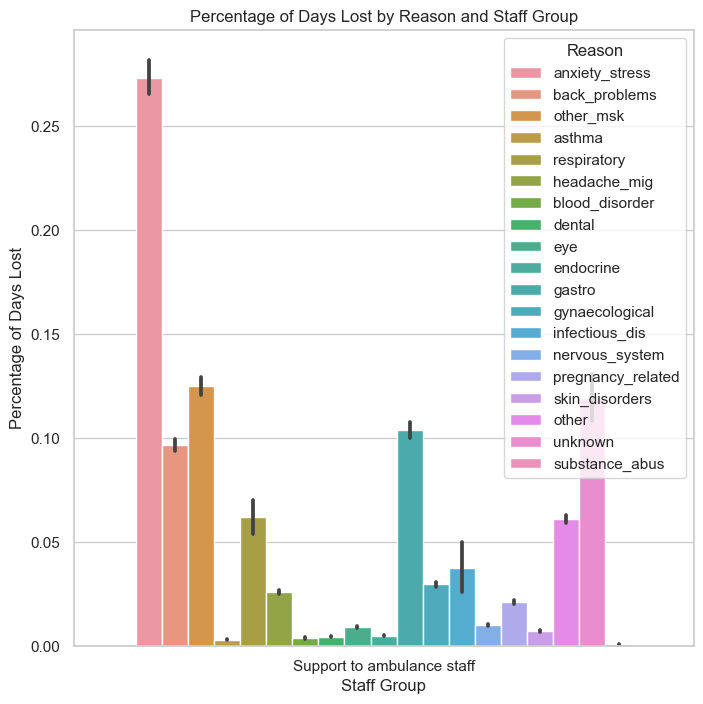

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a grouped bar plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
sns.barplot(x='Staff group', y='percentage_days_lost', hue='reason_short', data=df_reason_sg)
plt.title('Percentage of Days Lost by Reason and Staff Group')
plt.xlabel('Staff Group')
plt.ylabel('Percentage of Days Lost')
plt.legend(title='Reason')
plt.show()

In [147]:
#df_reason['Description']
# Group the data by 'reason' and calculate the total days lost for each reason
#reasons_totals = df_reason.groupby('Description')['FTE days lost'].sum().reset_index()

# Sort the DataFrame by 'days_lost' in descending order
#reasons_totals = reasons_totals.sort_values(by='FTE days lost', ascending=False)

#reasons_totals

In [148]:
df_reason.to_csv('../sickness_absence_reason.csv', index=False)


### Process and save sickness absence due to COVID data

Filter the 'Downloaded From' for cells containing "COVID-19" because that picks up on sickness absence reason data. 

In [24]:
covid19_df = combined_df[combined_df['Downloaded From'].str.contains('COVID-19')].dropna(axis = 1,
                                                                                          how = 'all').dropna(axis = 0,
                                                                                          how = 'all').reset_index(drop=True)

In [30]:
covid19_df = covid19_df.drop(['Downloaded From'], axis=1)

In [32]:
covid19_df = covid19_df.dropna(subset=['FTE_DAYS_AVAILABLE'])


In [33]:
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56297 entries, 0 to 69879
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE                 56297 non-null  object 
 1   NHSE_REGION_CODE     56297 non-null  object 
 2   NHSE_REGION_NAME     56297 non-null  object 
 3   ORG_CODE             56297 non-null  object 
 4   ORG_NAME             56297 non-null  object 
 5   FTE_DAYS_LOST        56036 non-null  float64
 6   FTE_DAYS_AVAILABLE   56297 non-null  float64
 7   STAFF_GROUP          56297 non-null  object 
 8   FTE_DAYS_LOST_COVID  54893 non-null  float64
 9   ICS_CODE             41433 non-null  object 
 10  ICS_NAME             41433 non-null  object 
dtypes: float64(3), object(8)
memory usage: 5.2+ MB


In [34]:
covid19_df.head()

,DATE,NHSE_REGION_CODE,NHSE_REGION_NAME,ORG_CODE,ORG_NAME,FTE_DAYS_LOST,FTE_DAYS_AVAILABLE,STAFF_GROUP,FTE_DAYS_LOST_COVID,ICS_CODE,ICS_NAME
0,30/04/2022,All NHSE regions,All NHSE regions,All organisations,All organisations,2.266051e+06,3.933588e+07,All staff groups,553048.14328,NaN,NaN
1,30/04/2022,All NHSE regions,All NHSE regions,All organisations,All organisations,3.186103e+05,7.200150e+06,NHS infrastructure support,61892.77509,NaN,NaN
2,30/04/2022,All NHSE regions,All NHSE regions,All organisations,All organisations,1.596052e+03,7.571534e+04,Other staff or those with unknown classification,552.36000,NaN,NaN
3,30/04/2022,All NHSE regions,All NHSE regions,All organisations,All organisations,1.049366e+06,2.032216e+07,Professionally qualified clinical staff,294080.27771,NaN,NaN
4,30/04/2022,All NHSE regions,All NHSE regions,All organisations,All organisations,8.964790e+05,1.173785e+07,Support to clinical staff,196522.73048,NaN,NaN


In [35]:
covid19_df.to_csv('../covid-19_sickness_absence.csv', index=False)


In [33]:
# import pickle
# with open('objs.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([absence_df, combined_df, covid19_df, df, df_reason, df_ref,p_reason_df,
#                  reason_df], f)

In [ ]:
#with open('objs.pkl') as f:  # Python 3: open(..., 'rb')
#    absence_df, combined_df, covid19_df, df, df_reason, df_ref,p_reason_df,reason_df = pickle.load(f)